In [1]:
# READING IMAGE #
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# %matplotlib qt
# ###VIEWING CHESSBOARD###
# image1 = mpimg.imread('./camera_cal/calibration1.jpg')
# image2 = mpimg.imread('./camera_cal/calibration2.jpg')
# f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
# f.tight_layout()
# ax1.imshow(image1)
# ax2.imshow(image2)
# plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)
# print(image1.shape)

## CALIBRATION

In [2]:
### FINDING IMAGE AND OBJECT POINTS ###
import numpy as np
import cv2
import glob
#Finding object points and image points
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []
images = glob.glob('./camera_cal/calibration*.jpg')
for name in images:
    img = mpimg.imread(name)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx, ny),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [11]:
#Covert RGB to Gray
def graycvt(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

#Histogram Equalization
def histogramEqual(image):
    img_yuv = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

#Define Region of Interest. Reference from P1 Help Code
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
#Convert to gray and Undistort Image
def undistort(image, objpoints, imgpoints):
    gray = graycvt(image)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

#Derivative Binary Thresholds
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = graycvt(img)
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0])&(scaled_sobel <= thresh[1])] = 1
    return grad_binary

#Magnitude Binary Thresholds
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0,255)):
    gray = graycvt(image)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0])&(scaled_sobel <= mag_thresh[1])]=1
    return mag_binary

#Directional Binary Thresholds
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = graycvt(image)
    abs_sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    grad_dir = np.arctan2(abs_sobely,abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0])&(grad_dir <= thresh[1])] = 1
    return dir_binary

#S channel 
def hls_select(image,thresh =(0,255)):
    hls = cv2.cvtColor(histogramEqual(image),cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0])&(s<=thresh[1])] = 1
    return binary_output

#V channel
def hsv_select(image,thresh=(0,255)):
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]
    binary_output = np.zeros_like(v)
    binary_output[(v > thresh[0]) & (v<=thresh[1])] = 1
    return binary_output

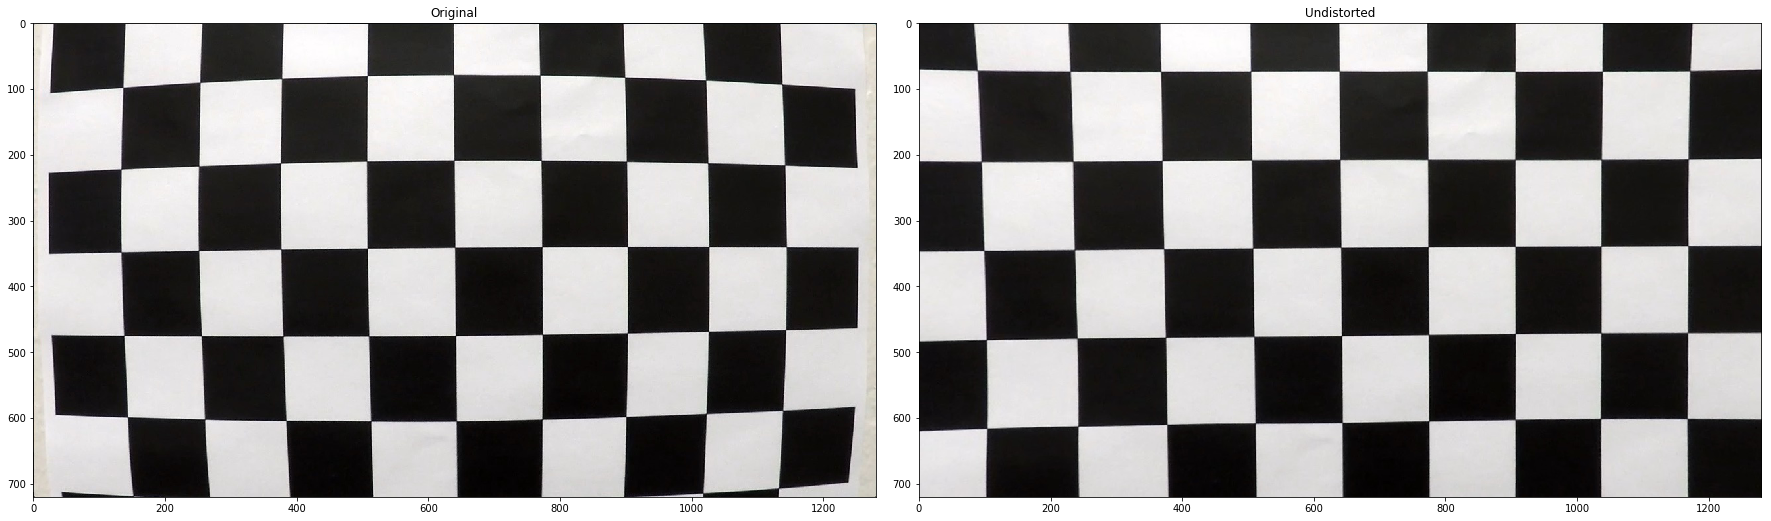

In [12]:
#Undistort a Chessboard Image
%matplotlib inline
ca1 = mpimg.imread('./camera_cal/calibration1.jpg')
undistort_ca1 = undistort(ca1, objpoints, imgpoints)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1)
ax1.set_title('Original')
ax2.imshow(undistort_ca1)
ax2.set_title('Undistorted')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

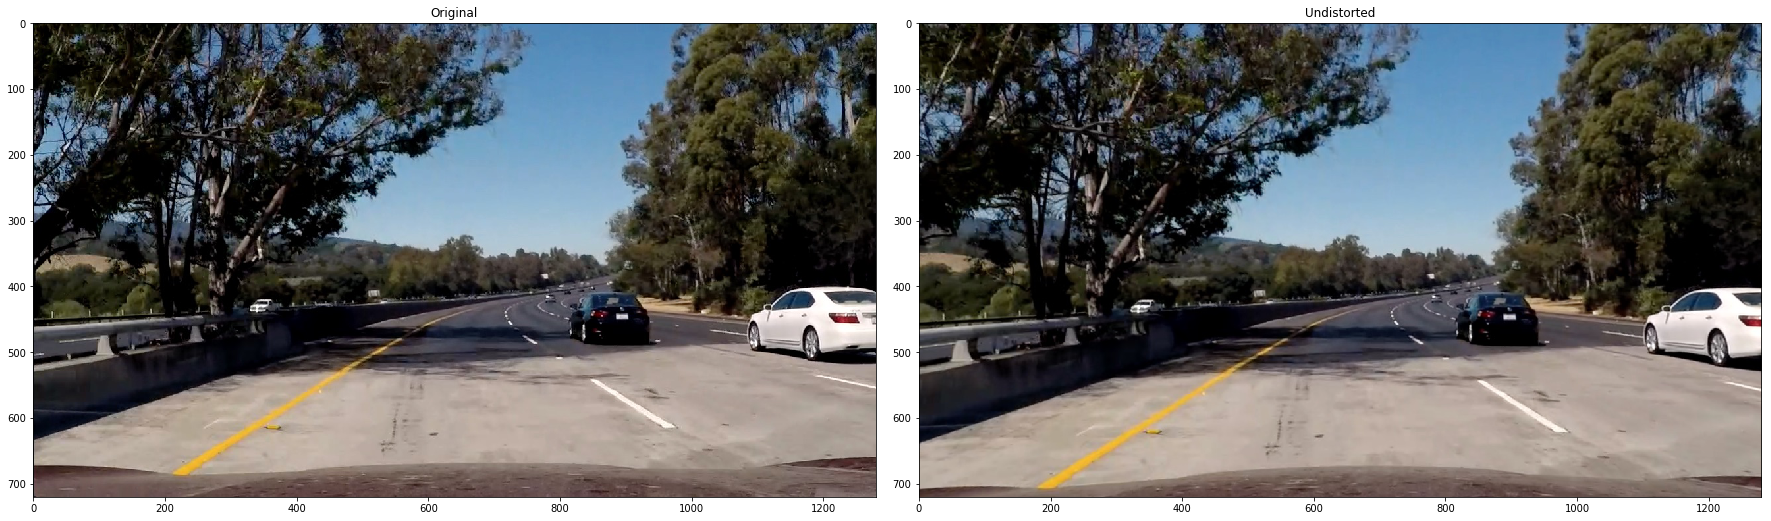

In [13]:
#Undistort a Test Image
%matplotlib inline
ca1 = mpimg.imread('./test_images/test5.jpg')
undistort_ca1 = undistort(ca1, objpoints, imgpoints)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(ca1)
ax1.set_title('Original')
ax2.imshow(undistort_ca1)
ax2.set_title('Undistorted')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

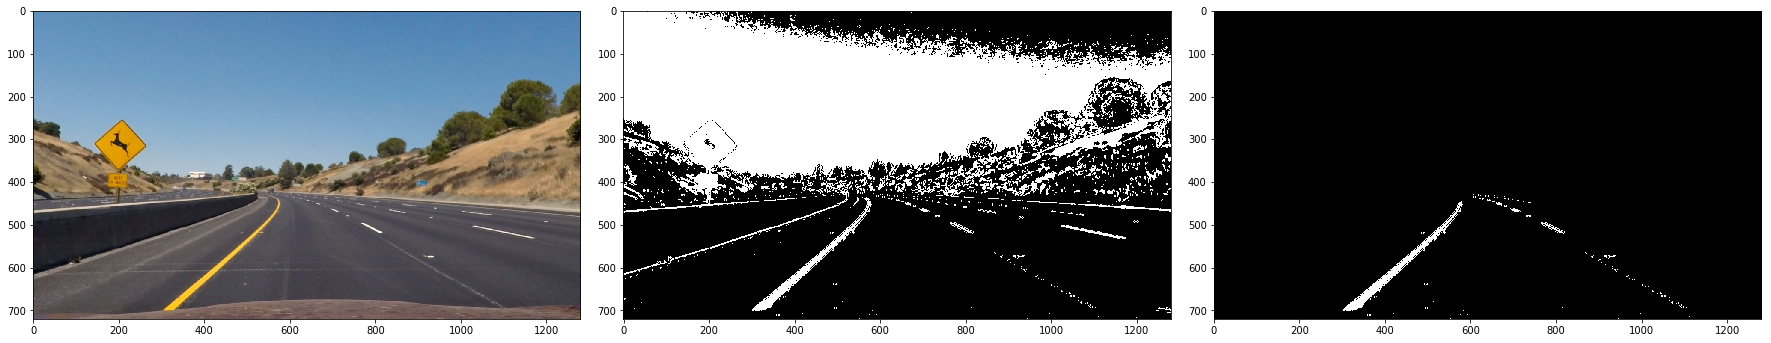

In [48]:
#Sample Binary Image and Mask Image
# %matplotlib qt
img1 = mpimg.imread('./test_images/test2.jpg')
undist = undistort(img1, objpoints, imgpoints)
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=9, thresh=(30,100))
s_channel = hls_select(undist, thresh = (120,255))
v_channel = hsv_select(undist,thresh=(75,255))
combined_binary = np.zeros_like(gradx)
combined_binary[(gradx == 1)|(s_channel == 1)&(v_channel == 1)]=1
imshape = combined_binary.shape
vertices = np.array([[(100,imshape[0]),(620,420),(750,450),(1200,imshape[0])]],dtype=np.int32)
binary_output = region_of_interest(combined_binary,vertices)
#Plot Images
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist)
ax2.imshow(combined_binary,cmap='gray')
ax3.imshow(binary_output,cmap='gray')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

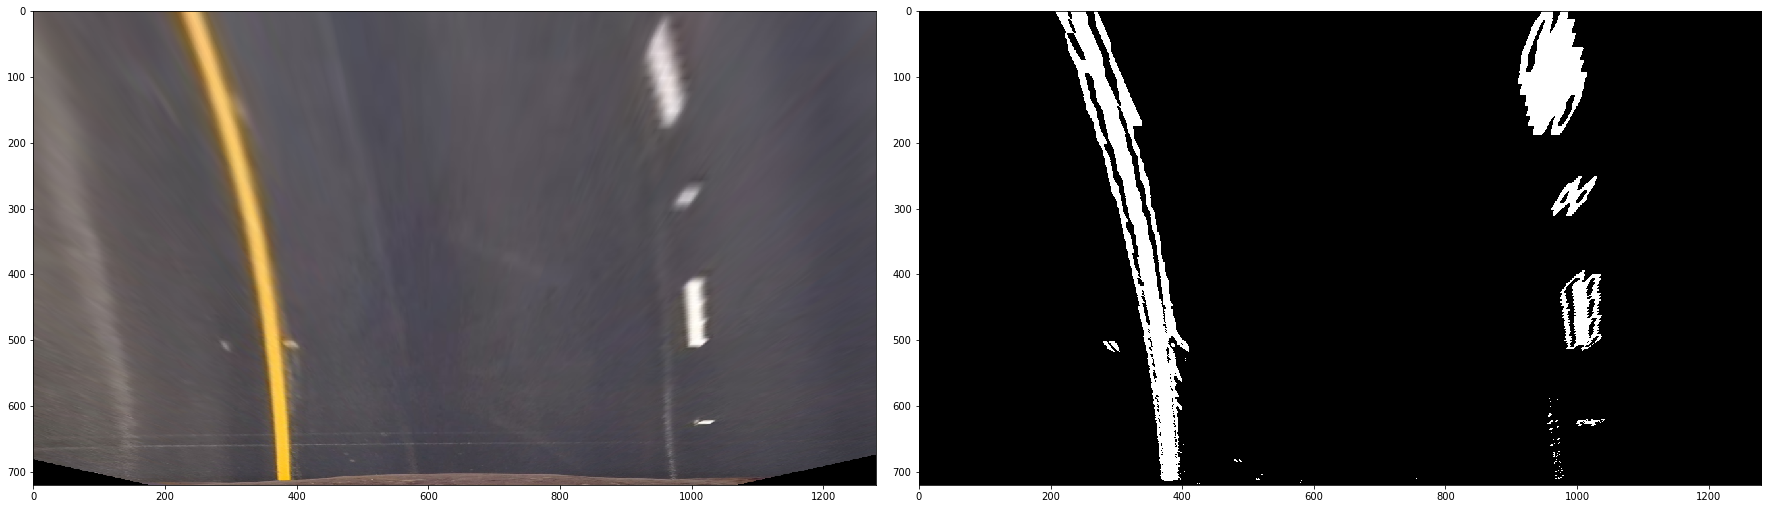

In [49]:
#Sample Bird Eye View
# src = np.float32([
#     [556,479],
#     [732,476],
#     [147,683],
#     [1046,683]])
# dst = np.float32([
#     [320,0],
#     [960,0],
#     [320,683],
#     [960,683]
# ])
src = np.float32([
    [585,460],
    [203,720],
    [1127,720],
    [695,460]])
dst = np.float32([
    [320,0],
    [320,720],
    [960,720],
    [960,0]])

M = cv2.getPerspectiveTransform(src,dst)
undist_warped = cv2.warpPerspective(undist,M,(1280,720))
binary_warped = cv2.warpPerspective(binary_output,M,(1280,720))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
f.tight_layout()
ax1.imshow(undist_warped)
ax2.imshow(binary_warped,cmap='gray')
plt.subplots_adjust(left=0.,right=1,top=0.9,bottom=0.)

In [ ]:
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:],axis=0)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#sliding window
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

leftx_current = leftx_base
rightx_current = rightx_base
margin = 100 #window width
minpix = 50 #min pixel found in each window
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - (window*window_height)
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin 
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                      & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                      & (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

#Pixel position for left and right
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

#Fit 2nd polynomial
left_fit = np.polyfit(lefty,leftx, 2)
right_fit = np.polyfit(righty,rightx,2)

#x & y values for plotting

out_img[lefty, leftx] = [255,0,0]
out_img[righty,rightx] = [0,0,255]

ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#Poly Fill Left Lane with +/- margin
# left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
# left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
# left_line_pts = np.hstack((left_line_window1,left_line_window2))
# print('win1',left_line_window1)
# print('win2',left_line_window2)
# print('left points',left_line_pts)

left_poly = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
right_poly = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
lane_poly = np.hstack((left_poly,right_poly))

window_img = np.zeros_like(out_img)
warp_copy = np.copy(undist_warped)
cv2.polylines(window_img,np.int32(left_poly),1,(255,0,0),50)
cv2.polylines(window_img,np.int32(right_poly),1,(255,0,0),50)
result = cv2.fillPoly(window_img,np.int_([lane_poly]),(0,255,0))
# result = cv2.addWeighted(,1,window_img,0.3,0)
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='blue',lw=5)
# plt.plot(right_fitx, ploty, color='blue',lw=5)
# plt.xlim(0,1280)
# plt.ylim(720,0)
# print(rightx_base)
src = np.float32([
    [556,479],
    [732,476],
    [269,683],
    [1046,683]])
dst = np.float32([
    [320,0],
    [960,0],
    [320,683],
    [960,683]
])
M = cv2.getPerspectiveTransform(dst,src)
un_warped = cv2.warpPerspective(result,M,(1280,720))
undist_copy = np.copy(undist)
final = cv2.addWeighted(undist_copy,1,un_warped,0.5,0)
plt.imshow(final)

In [ ]:
def binary(image):
    undist = undistort(image, objpoints, imgpoints)
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=9, thresh=(30,100))
    s_channel = hsl_select(undist, thresh=(120,255))
    v_channel = hsv_select(undist, thresh=(75,255))
    combined_binary = np.zeros_like(gradx)
    combined_binary[(gradx==1)|(s_channel==1) & (v_channel ==1)]=1
    imshape = combined_binary.shape
    vertices = np.array([[(100,imshape[0]),(600,450),(750,450),(1200,imshape[0])]],dtype=np.int32)
    binary_output = region_of_interest(combined_binary,vertices)
    return undist, binary_output

def perspectiveTransform(image,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    transform_img = cv2.warpPerspective(image,M,(1280,720))
    return transform_img

def measureCurvature(ploty,leftx,lefty,rightx,righty):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    ymax = np.max(ploty)
    left_poly = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_poly = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix,2)
    left_cur = ((1+(2*left_poly[0]*ymax*ym_per_pix + 
                          left_poly[1])**2)**1.5)/np.absolute(2*left_poly[0])
    right_cur = ((1+(2*right_poly[0]*ymax*ym_per_pix + 
                          right_poly[1])**2)**1.5)/np.absolute(2*right_poly[0])
    radius = (left_cur+right_cur)/2
    return radius

def offcenter(image,ploty,left_fit,right_fit):
    ymax = np.max(ploty)
    x_per_pix = 3.7/700
    leftx_bottom = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    rightx_bottom = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    center_lanes = (leftx_bottom + rightx_bottom)/2
    center_image = image.shape[1]/2
    off_center = (center_image-center_lanes)*x_per_pix
    return off_center

def process(image):
#     src = np.float32([
#         [556,479],
#         [732,476],
#         [269,683],
#         [1046,683]])
#     dst = np.float32([
#         [320,0],
#         [960,0],
#         [320,683],
#         [960,683]])
    src = np.float32([
        [585,460],
        [203,720],
        [1127,720],
        [695,460]])
    dst = np.float32([
        [320,0],
        [320,720],
        [960,720],
        [960,0]])
    undist, binary_output = binary(image)
    binary_warped = perspectiveTransform(binary_output,src,dst)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    global left_fit, right_fit, left_poly_list, right_poly_list
    if (left_fit, right_fit) == (None,None):
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:],axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        #sliding window
        nwindows = 9
        window_height = np.int(binary_warped.shape[0]/nwindows)
        leftx_current = leftx_base
        rightx_current = rightx_base
        minpix = 50 #min pixel found in each window
        left_lane_inds = []
        right_lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - (window*window_height)
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin 
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) 
                          & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        #Pixel position for left and right
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        #Fit 2nd polynomial
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx,2)
        left_poly_list = np.array([left_fit])
        right_poly_list = np.array([right_fit])
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                         (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        #Pixel position for left and right
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        #Fit 2nd polynomial
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx,2)
        
    #Average poly coefficient up to the last 10 frames
    left_poly_list = np.concatenate((left_poly_list,[left_fit]),axis=0)[-10:]
    right_poly_list = np.concatenate((right_poly_list,[right_fit]),axis=0)[-10:]
    left_fit = np.average(left_poly_list,axis=0)
    right_fit = np.average(right_poly_list,axis=0)
    
    #x & y values for plotting
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty,rightx] = [0,0,255]

    ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_poly = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    right_poly = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    lane_poly = np.hstack((left_poly,right_poly))

    window_img = np.zeros_like(out_img)
    cv2.polylines(window_img,np.int32(left_poly),1,(255,0,0),50)
    cv2.polylines(window_img,np.int32(right_poly),1,(255,0,0),50)
    result = cv2.fillPoly(window_img,np.int_([lane_poly]),(0,255,0))


    un_warped = perspectiveTransform(result,dst,src)
    undist_copy = np.copy(undist)
    final = cv2.addWeighted(undist_copy,1,un_warped,0.5,0)
    
    #Curvature
    radius = measureCurvature(ploty,leftx,lefty,rightx,righty)
    off_center = offcenter(final,ploty,left_fit,right_fit)
    cv2.putText(final,'Radius of Curvature: %.3f (m)' % radius,(20,40),cv2.FONT_HERSHEY_SIMPLEX,
                               1,(0,0,255),1,cv2.LINE_AA)
    cv2.putText(final,'Vehicle is %.3f (m) to the left of the center' % off_center,(20,80),cv2.FONT_HERSHEY_SIMPLEX,
                               1.25,(0,255,255),3,cv2.LINE_AA)
    return final
    
    

In [ ]:
%matplotlib qt
img1 = mpimg.imread('./test_images/test5.jpg')
left = 1
cv2.putText(img1,'Radius: '+str(left),(20,40),cv2.FONT_HERSHEY_SIMPLEX,
                               1.25,(0,255,255),3,cv2.LINE_AA)
final_add = cv2.putText(img1,'Off Centers: '+str(left),(20,80),cv2.FONT_HERSHEY_SIMPLEX,
                               1.25,(0,255,255),3,cv2.LINE_AA)
plt.imshow(final_add)



In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_vid.mp4'
clip1 = VideoFileClip('project_video.mp4')
left_fit, right_fit = None, None
project_clip = clip1.fl_image(process)
%time project_clip.write_videofile(project_output, audio=False)


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output1 = 'project_vid2.mp4'
clip11 = VideoFileClip('project_video.mp4')
left_fit, right_fit = None, None
left_poly_list, right_poly_list = None, None
project_clip1 = clip11.fl_image(process)
%time project_clip1.write_videofile(project_output1, audio=False)